In [1]:
from google.colab import drive
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [2]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/AN2DL_MY_FOLDER/My_Network_Trials/homework2

[Errno 2] No such file or directory: '/content/drive/MyDrive/AN2DL_MY_FOLDER/My_Network_Trials/homework2'
/content


In [5]:
drive.mount('/gdrive')
os.chdir(r'/gdrive/MyDrive/annHomework2/')
x_train = np.load(r'x_train.npy')
y_train = np.load(r'y_train.npy')

Mounted at /gdrive


In [6]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

Is it already divided into windows? I would say yes. 

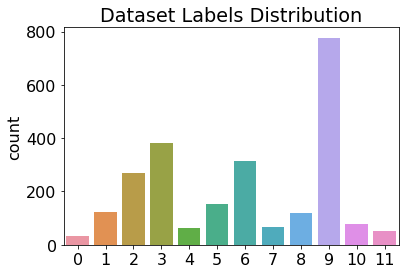

In [7]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

As we can see dataset is pretty unbalanced. But, looking at early subs, more prominent classes do not seem to be the best predicted. Why? 

In [8]:
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 
y_train = tfk.utils.to_categorical(y_train) 

In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 

In [10]:
train_data = np.concatenate([x for x in x_train]) 
scaler = preprocessing.StandardScaler().fit(train_data)

x_train_trans = [] 
for el in x_train: 
  x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
  x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)

#x_train

In [11]:
# check 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 
x_train[0][1]
y_train[0]

(1943, 36, 6) (1943, 12) (486, 36, 6) (486, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# **TRANSFORMER**

In [12]:
input_shape = (36,6)

#### 1D Convolutional Neural Network

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

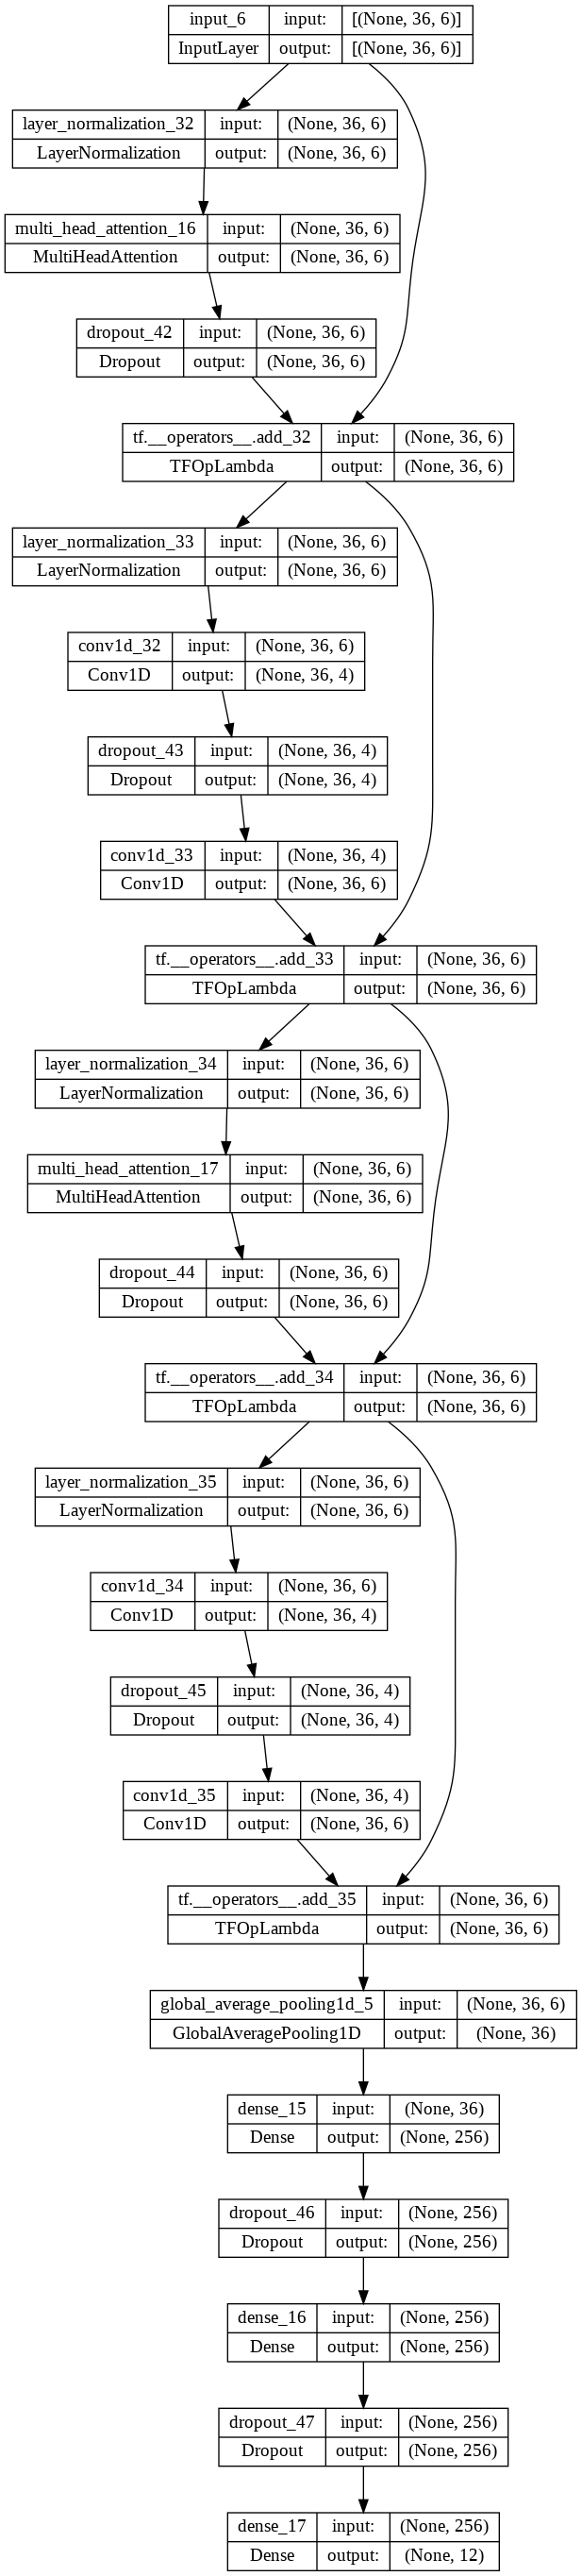

In [40]:
layers = tfkl 
keras = tfk
n_classes = 12

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks=3,
    mlp_units=2,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=5,
    ff_dim=4,
    num_transformer_blocks=2, 
    mlp_units=[256, 256],
    mlp_dropout=0.1,
    dropout=0.1,
)

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.01), metrics='accuracy')
tfk.utils.plot_model(model, show_shapes=True)

In [41]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 36, 6)       12          ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 36, 6)       34566       ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [42]:
history1 = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.2, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 3s 30ms/step - loss: 2.4464 - accuracy: 0.2162 - val_loss: 2.2111 - val_accuracy: 0.3251 - lr: 0.0100
Epoch 2/200
31/31 [==============================] - 1s 16ms/step - loss: 2.0404 - accuracy: 0.3608 - val_loss: 2.0882 - val_accuracy: 0.3724 - lr: 0.0100
Epoch 3/200
31/31 [==============================] - 0s 15ms/step - loss: 1.9114 - accuracy: 0.3706 - val_loss: 2.1746 - val_accuracy: 0.3868 - lr: 0.0100
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 1.8415 - accuracy: 0.4004 - val_loss: 2.1112 - val_accuracy: 0.3930 - lr: 0.0100
Epoch 5/200
31/31 [==============================] - 0s 15ms/step - loss: 1.8097 - accuracy: 0.3963 - val_loss: 2.3319 - val_accuracy: 0.3930 - lr: 0.0100
Epoch 6/200
31/31 [==============================] - 0s 16ms/step - loss: 1.8167 - accuracy: 0.4020 - val_loss: 2.0280 - val_accuracy: 0.4095 - lr: 0.0100
Epoch 7/200
31/31 [==============================] - 0s 15ms/step - lo

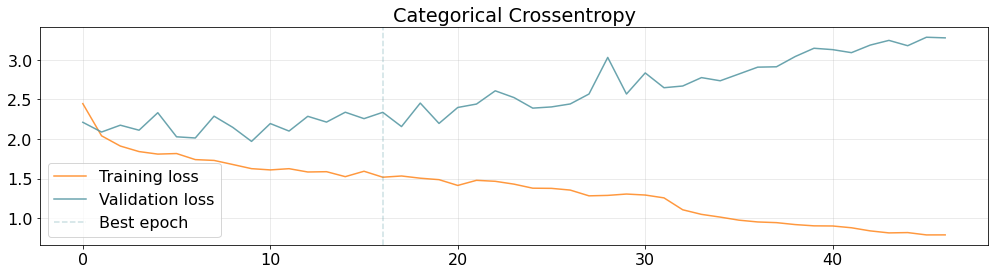

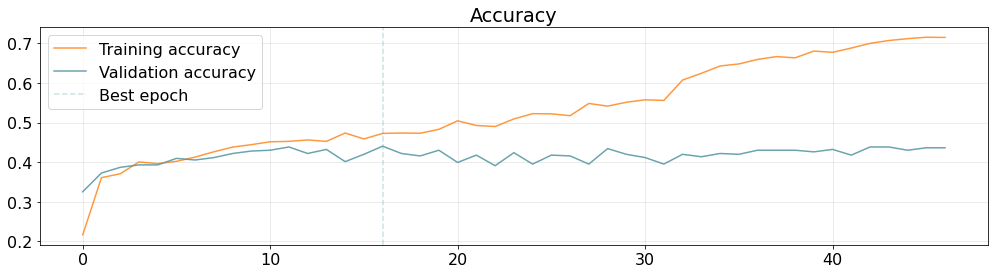

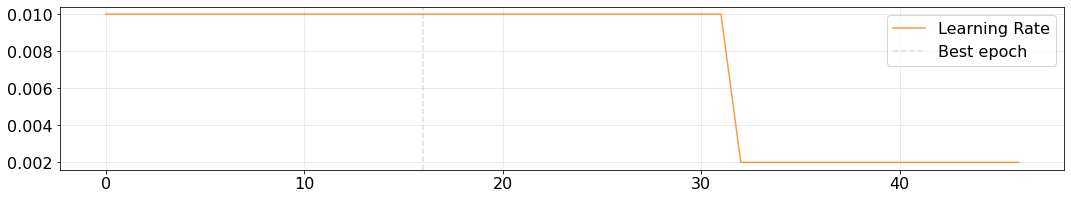

In [43]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [44]:
#model.save('1DCNN')

In [45]:
predictions = model.predict(x_test)
predictions.shape

16/16 [==============================] - 0s 4ms/step


(486, 12)

16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}
16/16 [==============================] - 0s 3ms/step
Accuracy: 0.4403
Precision: 0.2386
Recall: 0.2156
F1: 0.2053
F1 (per class): [0.         0.         0.58333333 0.02409639 0.         0.
 0.3875969  0.         0.44444444 0.59713701 0.27272727 0.15384615]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


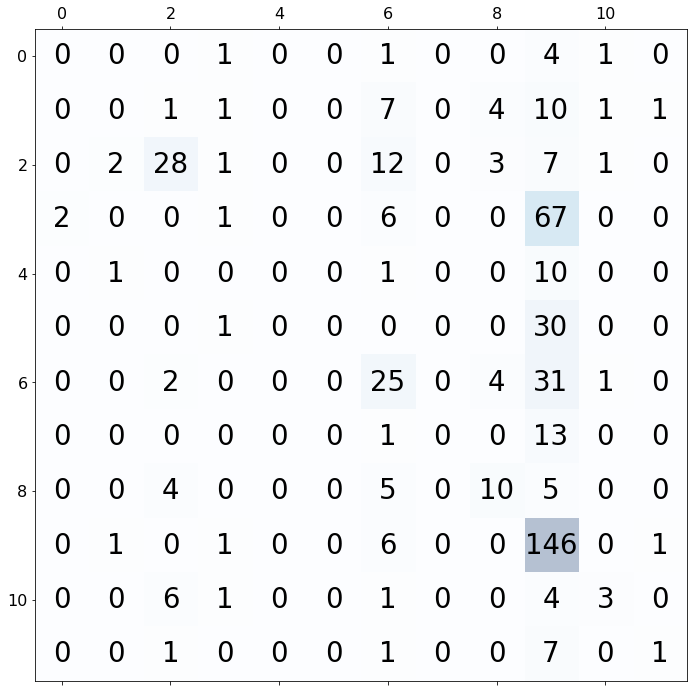

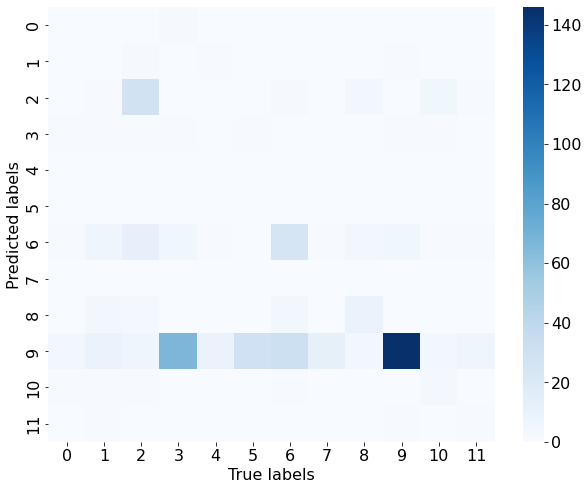

In [46]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()